# Reinforcement Learning Project: Maze Extended

We create a maze for an agent to navigate out.

This tutorial is extended from this post.
- https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

However, here, we increased the number of moves that can be implemented
- Initially, there is only horizontal and vertical movement
- Now, we include diagonal movements

Also, we increase the map size to 8 by 8, and make the maze more complicated

# Import Library and Define Possible Actions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Possible Action that can be done by the agent
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1),
           'UL': (-1,-1), 'UR': (-1,1), 'DL': (1,-1), 'DR': (1,1)}

# Maze

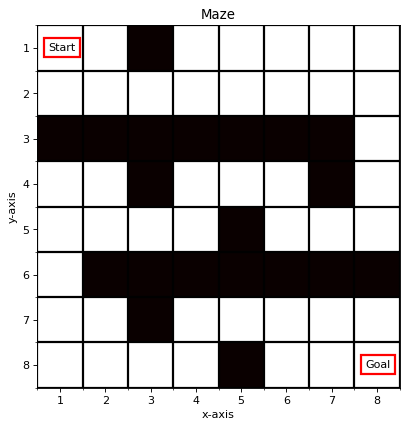

In [2]:
maze = np.zeros((8, 8))
maze[0, 2] = -10000
maze[3, 6] = -10000
maze[4, 4] = -10000
maze[7, 4] = -10000
maze[2, 0:7] = -10000
maze[5, 1:8] = -10000
maze[5:7, 2] = -10000
maze[3, 2] = -10000
        
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(maze, 
           cmap='hot', 
          )

plt.text(7-0.25, 7+0.05, 'Goal', color='black', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(-0.25, 0.05, 'Start', color='black', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 8, 1))
ax.set_yticks(np.arange(0, 8, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 9, 1))
ax.set_yticklabels(np.arange(1, 9, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 8, 1), minor=True)
ax.set_yticks(np.arange(-.5, 8, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

plt.title('Maze')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

plt.show()

# Define Maze Class

## Initialize
1. Maze
2. Track movement history
3. Robot position, allowed states, etc

## Methods
1. is_allowed_move: Check if the agent is allowed to move in this direction
2. construct_allowed_states: Check where is the agent allowed to move
3. update_maze: Update the position of the agent
4. is_game_over: Check if the game is ended
5. give_reward: Compute the reward after each actions
6. get_state_and_reward: Get the position and reward after each action

In [3]:
class Maze(object):
    
    def __init__(self):

        #################################################################
        # Defining the Maze
        #################################################################
        self.size = 8
        
        self.maze = np.zeros((self.size, self.size))
        self.maze[0, 0] = 2
        self.maze[1, 5] = 1
        self.maze[0, 2] = 1
        self.maze[3, 6] = 1
        self.maze[4, 4] = 1
        self.maze[7, 4] = 1
        self.maze[2, 0:7] = 1
        self.maze[5, 1:8] = 1
        self.maze[5:7, 2] = 1
        self.maze[3, 2] = 1
        
        #################################################################
        # Keep track of movement history
        #################################################################
        self.movement_history = []
        
        #################################################################
        # Others
        #################################################################
        self.robot_position = (0, 0)     # current robot position
        self.steps = 0                   # contains num steps robot took
        self.allowed_states = None       # for now, this is none
        self.construct_allowed_states()  # not implemented yet
        
        
    #################################################################
    # Check if the agent is allowed to move in a specific direction
    #################################################################
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        
        # Moving off the board
        if ((y < 0) or 
            (x < 0) or 
            (y > self.size-1) or 
            (x > self.size-1)):
             return False
        
        # Moving into start position or empty space
        if self.maze[y, x] == 1:
            return False
        else:
            return True
        
    #################################################################
    # Find all the directions that the agent is allowed to move
    #################################################################
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # Iterate through all valid spaces
                if self.maze[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
                            
        self.allowed_states = allowed_states
        
        
    #################################################################
    # Update the position of the agent within the maze
    #################################################################
    def update_maze(self, action):
        
        y, x = self.robot_position
        
        # Set the current position to empty
        self.maze[y, x] = 0
        
        # Find new position
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2
        self.steps += 1
        
        # Keep track of the path the agent moved
        self.movement_history.append(action)

        
    #################################################################
    # If the agent reach the end, ends the game
    #################################################################
    def is_game_over(self):
        if self.robot_position == (self.size-1, self.size-1):
            
            #print('Actions required:', self.steps)
            #print(self.maze)
            #print('Actions:', self.movement_history)
            
            return True
        return False
    
    #################################################################
    # At every step, give reward
    #################################################################
    def give_reward(self):
        if self.robot_position == (self.size-1, self.size-1):
            return 0
        else:
            return -1
        
    #################################################################
    # Update agent position and reward
    #################################################################
    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

# Define Agent Class

## Initialize
1. State history
2. Alpha - Learning rate
3. Random factor - Exploration rate
4. Reward table G

## Methods
1. init_reward: Generate a random reward table
2. choose_action: From the list of actions allowed, select one action to perform based on G and random factor
3. update_state_history: Update the state and reward
4. learn: Update the reward table G

In [4]:
class Agent(object):
    
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        
        #################################################################
        # Define intial variables
        #################################################################
        self.state_history = [((0, 0), 0)] # State (x,y), reward
        self.alpha = alpha                 # Learning rate
        self.random_factor = random_factor # Exploration rate
        
        #################################################################
        # Initialize reward table
        #################################################################
        self.G = {}
        self.init_reward(states)
        
    #################################################################
    # Initalize reward table with values 0.1-1.0
    #################################################################
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
                
    #################################################################
    # Choose direction to move
    #################################################################
    def choose_action(self, state, allowed_moves):
        next_move = None
        
        # Generate a random number 0 to 1
        n = np.random.random()
        
        # If n < self.random_factor -> Explore -> Go any random move
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
            
        # Eploit -> Go the path with highest expected reward
        else:
            # some really small random number
            maxG = -10e15
            
            # From all the allowed move
            # Find the one with the highest reward and go there
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move
    
    #################################################################
    # Update the state history
    #################################################################
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

        
    #################################################################
    # Update the reward table
    #################################################################
    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []
        
        # Reduce exploration rate over time
        self.random_factor -= 10e-5 # decrease random factor each episode of play
        #print(self.random_factor)

# Check the inital reward table of the agent

In [5]:
maze = Maze()
robot = Agent(maze.maze, 
              alpha=0.1,         # Learning rate 
              random_factor=0.25 # Exploration rate
             )

robot.G

{(0, 0): 0.303110226574188,
 (1, 0): 0.923410744157985,
 (2, 0): 0.5254321362740562,
 (3, 0): 0.23520591684507114,
 (4, 0): 0.25292752511851146,
 (5, 0): 0.7346429030371767,
 (6, 0): 0.9403508087020438,
 (7, 0): 0.5880619763439723,
 (0, 1): 0.793309000340142,
 (1, 1): 0.8382385828651977,
 (2, 1): 0.24391358581389277,
 (3, 1): 0.7125070414478752,
 (4, 1): 0.7213676845438612,
 (5, 1): 0.8269921345741085,
 (6, 1): 0.8273323660754089,
 (7, 1): 0.1942028809944999,
 (0, 2): 0.7892416539817044,
 (1, 2): 0.6382498844908557,
 (2, 2): 0.7808486532110671,
 (3, 2): 0.46646513125284417,
 (4, 2): 0.3154288281348,
 (5, 2): 0.7367747205449143,
 (6, 2): 0.21590022161878722,
 (7, 2): 0.576908981524615,
 (0, 3): 0.5396125571368287,
 (1, 3): 0.9779370084068232,
 (2, 3): 0.2819661617398312,
 (3, 3): 0.4554354821611638,
 (4, 3): 0.6717896095454043,
 (5, 3): 0.36193480579392046,
 (6, 3): 0.6650760797784976,
 (7, 3): 0.6630300337388109,
 (0, 4): 0.8239354930344178,
 (1, 4): 0.19287872927472177,
 (2, 4): 0.445

# Run main and let the agent learn from the environment

In [6]:
if __name__ == '__main__':
    
    # Create Maze and Agent
    maze = Maze()
    robot = Agent(maze.maze, 
                  alpha=0.1,         # Learning rate 
                  random_factor=0.25 # Exploration rate
                 )
    size = maze.size
    moveHistory = []

    # Loop for 3000 times
    for i in range(3000):
        #print('\nLoop:', i+1)

        # Reinitialize the maze
        maze = Maze()
        
        # Conduct an action per turn
        while not maze.is_game_over():
            # Get the current state
            state, _ = maze.get_state_and_reward()
            
            # choose an action (explore or exploit)
            action = robot.choose_action(state, maze.allowed_states[state])
            
            # Update the maze according to the action
            maze.update_maze(action)
            
            # Get the new state and reward
            state, reward = maze.get_state_and_reward()
            
            # Update the robot memory with state and reward
            robot.update_state_history(state, reward)
            
            if maze.steps > 1000:
                # End the robot if it takes too long to find the goal
                # Set position to (5,5) to end the game
                maze.robot_position = (size-1,size-1)
        
        # Robot should learn after every episode
        robot.learn()
        
        if i%250 == 0:
            print('\nLoop:', i+1)
            print(maze.movement_history)
        
        # Get a history of number of steps taken to plot later
        moveHistory.append(maze.steps)


Loop: 1
['D', 'UR', 'DR', 'R', 'L', 'UL', 'DR', 'R', 'L', 'R', 'L', 'UL', 'DR', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'U', 'DL', 'R', 'L', 'UR', 'DL', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'UR', 'DL', 'L', 'R', 'R', 'L', 'L', 'UL', 'DL', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'R', 'R', 'L', 'R', 'U', 'DL', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UL', 'DL', 'UR', 'DR', 'R', 'R', 'L', 'L', 'R', 'U', 'DL', 'R', 'L', 'R', 'R', 'UL', 'DL', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'UR', 'D', 'L', 'L', 'R', 'R', 'U', 'DL', 'R', 'U', 'D', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'UL', 'DR', 'UR', 'DL', 'R', 'L', 'R', 'U', 'DL', 'R', 'L', 'R', 'L', 'R', 'U', 'D', 'L', 'UL', 'DR', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'UR', 'DL', 'L', 'UL', 'DR', 'R', 'L', 'R', 'L', 'R', 'R', 'UL', 'DL', 'R', 'R', 'L', 'U', 'DR', 'L', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'R'

# Plot Steps Rquired before game over or terminated

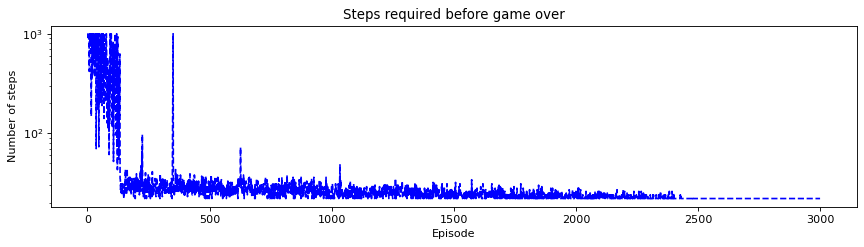

In [7]:
plt.figure(figsize=(13, 3), dpi=80)
plt.semilogy(moveHistory, "b--")
plt.title('Steps required before game over')
plt.ylabel('Number of steps')
plt.xlabel('Episode')
plt.show()

# Check the updated reward table of the agent

In [8]:
robot.G

{(0, 0): -23.667247763173066,
 (1, 0): -22.30373398275505,
 (2, 0): 0.24319178194652985,
 (3, 0): -8.560232124456169,
 (4, 0): -7.459911118124123,
 (5, 0): -6.0000000000000036,
 (6, 0): -6.273429010532229,
 (7, 0): -6.494412194422237,
 (0, 1): -21.205412227600444,
 (1, 1): -20.000000000000014,
 (2, 1): 0.144670565582374,
 (3, 1): -8.461133383989747,
 (4, 1): -7.0000000000000036,
 (5, 1): 0.9637556879700158,
 (6, 1): -5.0000000000000036,
 (7, 1): -5.187059002266644,
 (0, 2): 0.7478567749374433,
 (1, 2): -19.000000000000014,
 (2, 2): 0.34051373832766674,
 (3, 2): 0.14628890923580964,
 (4, 2): -8.000000000000007,
 (5, 2): 0.4002598357845234,
 (6, 2): 0.28301295109557834,
 (7, 2): -4.0000000000000036,
 (0, 3): -18.000000000000014,
 (1, 3): -19.184362621977442,
 (2, 3): 0.3104501724293748,
 (3, 3): -9.790355884683196,
 (4, 3): -9.000000000000007,
 (5, 3): 0.36562656380970415,
 (6, 3): -3.0000000000000018,
 (7, 3): -3.3264767202468906,
 (0, 4): -17.000000000000014,
 (1, 4): -18.0195728956520

# We visualize the reward table across the environment (x,y)
We set the "walls" to be -10000

Note:
- Only the goal is 0
- The other path will always be a negative value

In [9]:
matrix_G = np.zeros((size,size))

for i in robot.G:
    x, y = i
    reward = robot.G[i]
    matrix_G[x,y] = reward

matrix_G = np.round(matrix_G,3)
matrix_G[matrix_G>0] = -10000

np.set_printoptions(suppress=True)
print(matrix_G)

[[   -23.667    -21.205 -10000.       -18.       -17.       -16.
     -17.508    -17.714]
 [   -22.304    -20.       -19.       -19.184    -18.02  -10000.
     -15.       -15.546]
 [-10000.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.       -14.   ]
 [    -8.56      -8.461 -10000.        -9.79     -10.       -12.335
  -10000.       -13.   ]
 [    -7.46      -7.        -8.        -9.    -10000.       -11.
     -12.       -13.671]
 [    -6.    -10000.    -10000.    -10000.    -10000.    -10000.
  -10000.    -10000.   ]
 [    -6.273     -5.    -10000.        -3.        -2.        -1.
      -0.        -0.046]
 [    -6.494     -5.187     -4.        -3.326 -10000.        -1.224
      -0.174      0.   ]]


# Print the best action set

In [10]:
maze.movement_history

['DR',
 'R',
 'UR',
 'R',
 'R',
 'DR',
 'DR',
 'D',
 'DL',
 'L',
 'UL',
 'DL',
 'L',
 'L',
 'DL',
 'DR',
 'DR',
 'UR',
 'R',
 'R',
 'R',
 'DR']

# Plot the reward table as a color map

<ipython-input-11-544cec150ba7>:17: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(10**-logthresh)


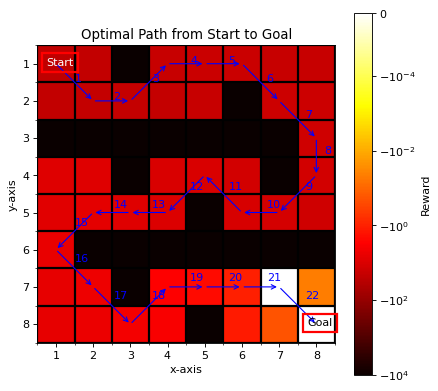

In [11]:
#################################################################
# Compute parameters to plot log scale color bar
#################################################################
logthresh = 5
vmin = np.min(matrix_G)
vmax = np.max([np.max(matrix_G), 1])
maxlog=int(np.ceil(np.log10(vmax) ))
minlog=int(np.ceil(np.log10(-vmin) ))

#################################################################
# Plot color map
#################################################################
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(matrix_G, 
           cmap='hot', 
           #interpolation='nearest',
           norm=matplotlib.colors.SymLogNorm(10**-logthresh)
          )

#################################################################
# Plot action path from start to goal
#################################################################
action_list = maze.movement_history

start_x = 0
start_y = 0
for i, action in enumerate(action_list):
    end_x = start_x + ACTIONS[action][0]
    end_y = start_y + ACTIONS[action][1]
    
    plt.annotate('', 
                 xytext=(end_y, end_x),
                 xy=(start_y, start_x), 
                 arrowprops=dict(arrowstyle="<-", color='blue'))
    
    x_mid = (start_x+end_x)/2
    y_mid = (start_y+end_y)/2
    
    plt.annotate(i+1, 
                 xytext=(y_mid, x_mid),
                 xy=(y_mid, x_mid), 
                 color='blue',
                 textcoords='offset points')
    
    start_x = end_x
    start_y = end_y

plt.text(size-0.25-1, size+0.05-1, 'Goal', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(-0.25, 0.05, 'Start', color='white', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
    
#################################################################
# Generate logarithmic ticks 
#################################################################
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-2)]
                +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1,2)])

#################################################################
# Generating grid for clearer illustration
#################################################################
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

#################################################################
# Add description
#################################################################
plt.title('Optimal Path from Start to Goal')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

cbar = plt.colorbar(ticks=tick_locations)
cbar.set_label('Reward')

plt.show()